# Milestone 3

In [1]:
# Imports
import pandas as pd
import numpy as np
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler

In [2]:
# Read data
voter_blocks_all = pd.read_csv('../data/MA_l2_2022stats_2020block/MA_l2_2022stats_2020block.csv', low_memory=False).set_index('geoid20')
voter_blocks_all.shape

(107292, 395)

In [3]:
# Group demographic columns together
registered = ['total_reg']
age = ['age_18_19', 'age_20_24', 'age_25_29','age_30_34','age_35_44', 'age_45_54', 'age_55_64', 'age_65_74','age_75_84', 'age_85over']
gender = [ 'voters_gender_m', 'voters_gender_f', 'voters_gender_unknown'] 
party = ['party_npp', 'party_dem', 'party_rep','party_lib', 'party_grn', 'party_con', 'party_ain', 'party_scl','party_oth', 'party_unk']
ethnicity1 = ['eth1_eur', 'eth1_hisp', 'eth1_aa',
                'eth1_esa', 'eth1_oth', 'eth1_unk']
ethnicity2 = ['eth2_euro', 'eth2_64',
                'eth2_93', 'eth2_10', 'eth2_30', 'eth2_23', 'eth2_66', 'eth2_34',
                'eth2_21', 'eth2_35', 'eth2_14', 'eth2_12', 'eth2_55', 'eth2_13',
                'eth2_32', 'eth2_61', 'eth2_85', 'eth2_29', 'eth2_33', 'eth2_38',
                'eth2_15', 'eth2_57', 'eth2_19', 'eth2_26', 'eth2_59', 'eth2_unk']
languages = ['languages_description_english', 'languages_description_spanish',
                'languages_description_portuguese',
                'languages_description_chinese', 'languages_description_italian',
                'languages_description_vietnamese', 'languages_description_other',
                'languages_description_unknown']
income = ['commercialdata_estimatedhhincomeamount_avg']


# Group variables related to the 2020 presidential election
presidential_2020 = ['g20201103_voted_all', 'g20201103_reg_all', 'g20201103_pct_voted_all',
                    'g20201103_voted_gender_m', 'g20201103_reg_gender_m',
                    'g20201103_pct_voted_gender_m', 'g20201103_voted_gender_f',
                    'g20201103_reg_gender_f', 'g20201103_pct_voted_gender_f',
                    'g20201103_voted_gender_unk', 'g20201103_reg_gender_unk',
                    'g20201103_pct_voted_gender_unk', 'g20201103_voted_eur',
                    'g20201103_reg_eur', 'g20201103_pct_voted_eur', 'g20201103_voted_hisp',
                    'g20201103_reg_hisp', 'g20201103_pct_voted_hisp', 'g20201103_voted_aa',
                    'g20201103_reg_aa', 'g20201103_pct_voted_aa', 'g20201103_voted_esa',
                    'g20201103_reg_esa', 'g20201103_pct_voted_esa', 'g20201103_voted_oth',
                    'g20201103_reg_oth', 'g20201103_pct_voted_oth', 'g20201103_voted_unk',
                    'g20201103_reg_unk', 'g20201103_pct_voted_unk']

## Data Cleaning and Processing

### Missingness

Issues to resolve:

- 'NO BLOCK ASSIGNMENT' entries

We are choosing to ignore and drop these values because of inappropriate assumptions that need to be made if trying to disaggregate these entries.

Similarly, using counties as our unit of observation is difficult due to there only being 14 counties.

It seems as though counties with lower population have higher proportion of unassigned voters.

We will also explore the excluded data to determine which population groups we might be disproportionately excluding.

- Missing income data 

We are aggregating our data to the Census Block Group level and taking the mean of the mean household income at the Census Block level weighted by the number of total voters in each Census Block.

- Null percentages

Drop Census Blocks that have zero population, useless for our analysis.

### Imbalance

Issues to resolve:

- Uneven distribution of voters among Census Blocks. 

Some Census Blocks are incredibly small, causing proportions to change wildly for small changes in counts.

We will aggregate the data to Census Block Groups to minimize the effects of incredibly small samples in Census Blocks.

In [4]:
# Drop 'NO BLOCK ASSIGNMENT' entries
voter_blocks = voter_blocks_all[~voter_blocks_all.index.str.contains('NO BLOCK ASSIGNMENT')].copy()

# Weighted mean function based on total registered voters
wm = lambda x: (
    np.average(x.dropna(), weights=voter_blocks.loc[x.dropna().index, 'total_reg'])
    if voter_blocks.loc[x.dropna().index, 'total_reg'].sum() > 0
    else np.nan
)

presidential_counts = [col for col in presidential_2020 if not '_pct_' in col]

agg_funcs = {col: 'sum' for col in [*registered, *age, *gender, *party, *ethnicity1, *languages, *presidential_counts]}
agg_funcs.update({'commercialdata_estimatedhhincomeamount_avg': wm})

voter_blocks['block_group_id'] = voter_blocks.index.str[:12]
block_groups = voter_blocks.groupby('block_group_id').agg(agg_funcs)

# Drop Census Blocks with zero voters registered during the 2020 presidential election
block_groups = block_groups[block_groups['g20201103_reg_all'] != 0]

# Rename the column
block_groups = block_groups.rename({'commercialdata_estimatedhhincomeamount_avg':'mean_hh_income'}, axis=1)

In [5]:
block_groups[block_groups['mean_hh_income'].isna()]

,total_reg,age_18_19,age_20_24,age_25_29,age_30_34,age_35_44,age_45_54,age_55_64,age_65_74,age_75_84,...,g20201103_reg_hisp,g20201103_voted_aa,g20201103_reg_aa,g20201103_voted_esa,g20201103_reg_esa,g20201103_voted_oth,g20201103_reg_oth,g20201103_voted_unk,g20201103_reg_unk,mean_hh_income
block_group_id,,,,,,,,,,,,,,,,,,,,,
250173840031,9,0,0,1,1,3,1,2,1,0,...,2,0,0,0,0,0,1,0,1,NaN
250250612021,2,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,NaN
250259809001,2,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,NaN
250259815021,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,NaN


In [6]:
print(f'After imputation, there are a total of {len(block_groups[block_groups['mean_hh_income'].isna()].index)} Census Block Groups still missing income data, with {block_groups[block_groups['mean_hh_income'].isna()]['total_reg'].sum()} voters in those Census Block Groups ({block_groups[block_groups['mean_hh_income'].isna()]['total_reg'].sum()/block_groups['total_reg'].sum():.5%} of the total).')

After imputation, there are a total of 4 Census Block Groups still missing income data, with 14 voters in those Census Block Groups (0.00031% of the total).


In [7]:
# Choose to drop NaN values for income due to low number of voters in these blocks.
block_groups = block_groups.dropna(subset='mean_hh_income')

In [8]:
print('\t\t\tBefore processing\tAfter processing')
print(f'Voters Registered:\t{voter_blocks_all['total_reg'].sum():,d}\t\t{block_groups['total_reg'].sum():,d}')
print(f'{(voter_blocks_all['total_reg'].sum() - block_groups['total_reg'].sum()) / voter_blocks_all['total_reg'].sum():.2%} of total registered voters were dropped.')

			Before processing	After processing
Voters Registered:	4,606,321		4,532,496
1.60% of total registered voters were dropped.


In [9]:
predictors = [*registered, *age, *gender, *party, *ethnicity1, *languages, 'mean_hh_income']
# Other potential response variables could be g20201103_voted_all or those who voted and are a part of a certain demographic group
response = 'g20201103_pct_voted_all'
block_groups[response] = block_groups['g20201103_voted_all'] / block_groups['g20201103_reg_all']
display(block_groups[predictors].describe())
display(block_groups[response].describe())

,total_reg,age_18_19,age_20_24,age_25_29,age_30_34,age_35_44,age_45_54,age_55_64,age_65_74,age_75_84,...,eth1_unk,languages_description_english,languages_description_spanish,languages_description_portuguese,languages_description_chinese,languages_description_italian,languages_description_vietnamese,languages_description_other,languages_description_unknown,mean_hh_income
count,5078.00000,5078.000000,5078.000000,5078.000000,5078.000000,5078.000000,5078.000000,5078.000000,5078.000000,5078.000000,...,5078.000000,5078.000000,5078.000000,5078.000000,5078.000000,5078.000000,5078.000000,5078.000000,5078.000000,5078.000000
mean,892.57503,13.099646,65.123868,73.480504,76.051595,137.494486,132.322765,158.668570,132.686491,74.901142,...,95.852501,395.705987,13.274321,3.392083,2.282001,1.875935,1.579756,7.240252,471.167586,116222.541632
std,425.44490,9.688161,37.504443,42.263991,41.339061,67.263632,74.045852,90.534879,79.594982,53.208951,...,55.728941,255.659902,17.540593,7.144205,5.383467,2.642579,3.610415,8.194707,199.716652,42906.112140
min,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,16463.671403
25%,591.00000,6.000000,39.000000,45.000000,47.000000,91.000000,80.000000,95.000000,77.000000,38.000000,...,57.000000,206.000000,3.000000,0.000000,0.000000,0.000000,0.000000,2.000000,326.000000,87292.016330
50%,799.00000,11.000000,57.000000,65.000000,69.000000,124.000000,116.000000,138.000000,115.000000,63.000000,...,85.000000,340.000000,7.000000,1.000000,1.000000,1.000000,0.000000,5.000000,432.000000,113576.636371
75%,1108.00000,17.000000,84.000000,92.000000,97.000000,173.000000,170.000000,205.000000,173.000000,100.000000,...,125.000000,527.000000,17.000000,3.000000,2.000000,3.000000,2.000000,9.000000,583.000000,143128.164779
max,3106.00000,107.000000,513.000000,445.000000,369.000000,471.000000,455.000000,570.000000,689.000000,798.000000,...,441.000000,1863.000000,236.000000,122.000000,123.000000,37.000000,84.000000,108.000000,1473.000000,271444.267135


count    5078.000000
mean        0.787553
std         0.112194
min         0.000000
25%         0.742466
50%         0.822727
75%         0.866915
max         1.000000
Name: g20201103_pct_voted_all, dtype: float64

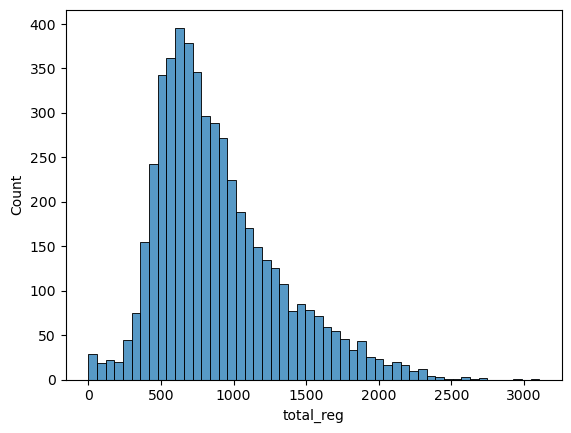

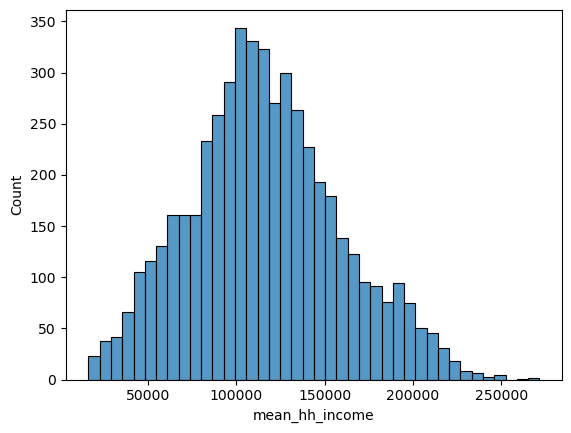

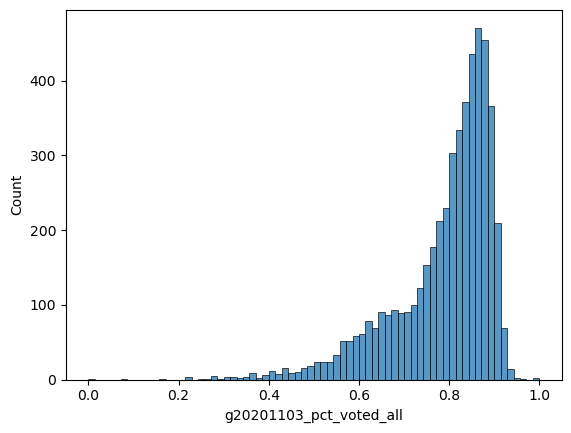

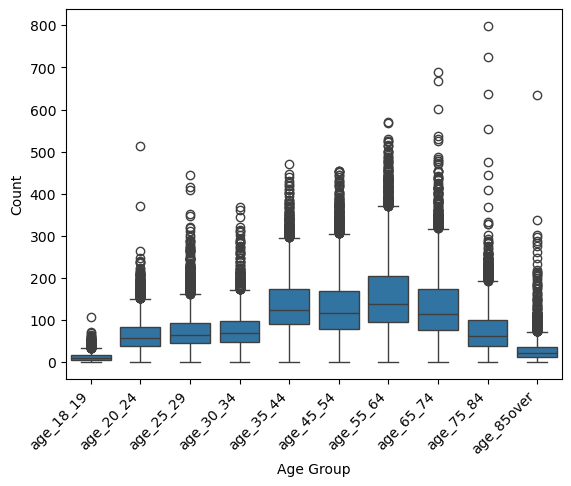

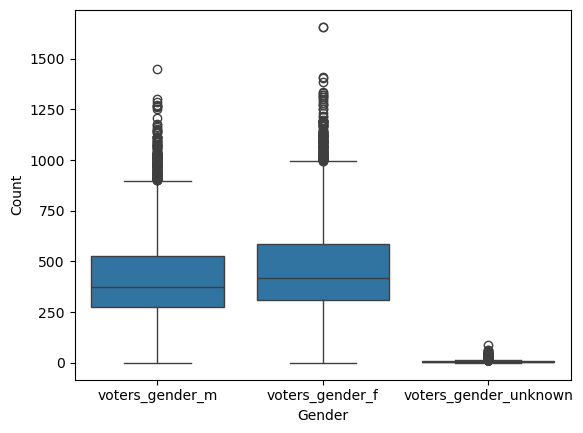

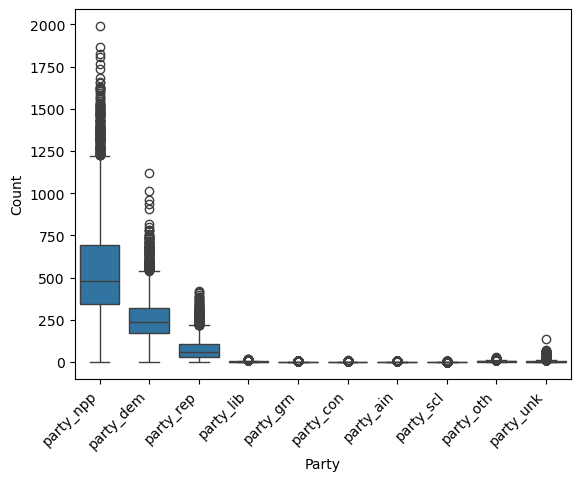

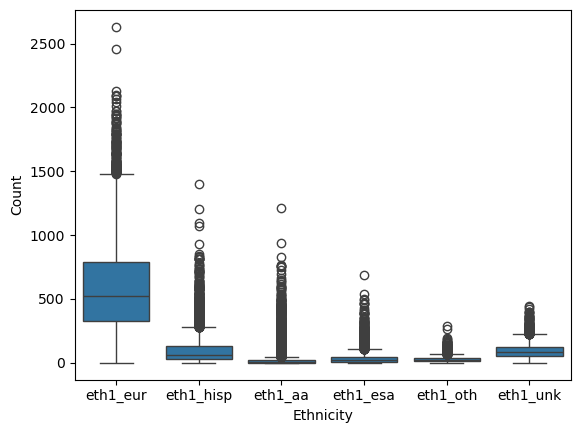

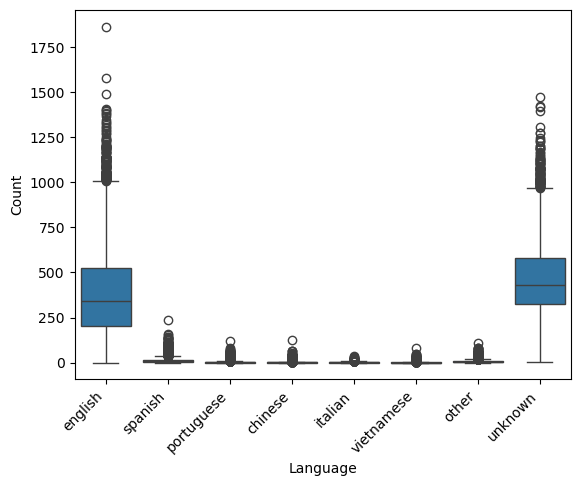

In [10]:
# Before transformation

sns.histplot(block_groups, x='total_reg')
# plt.yscale('log')
plt.show()

sns.histplot(block_groups, x='mean_hh_income')
# plt.yscale('log')
plt.show()

sns.histplot(block_groups, x=response)
# plt.yscale('log')
plt.show()

sns.boxplot(block_groups.melt(value_vars=age,var_name='Age Group',value_name='Count'),x='Age Group', y='Count')
plt.xticks(rotation=45, ha='right')
# plt.yscale('log')
plt.show()

sns.boxplot(block_groups.melt(value_vars=gender,var_name='Gender',value_name='Count'), x='Gender', y='Count')
# plt.yscale('log')
plt.show()

sns.boxplot(block_groups.melt(value_vars=party,var_name='Party',value_name='Count'), x='Party', y='Count')
plt.xticks(rotation=45, ha='right')
# plt.yscale('log')
plt.show()

sns.boxplot(block_groups.melt(value_vars=ethnicity1,var_name='Ethnicity',value_name='Count'), x='Ethnicity', y='Count')
# plt.yscale('log')
plt.show()

sns.boxplot(block_groups.melt(value_vars=languages,var_name='Language',value_name='Count'), x='Language', y='Count')
plt.xticks(ticks=np.arange(len(languages)),labels=[lang[len('languages_description_'):] for lang in languages], rotation=45, ha='right')
# plt.yscale('log')
plt.show()

In [11]:
# Take proportions
for cat in [*age, *gender, *party, *ethnicity1, *languages]:
    block_groups[cat] = block_groups[cat] / block_groups['total_reg']

for cat_set in [registered, age, gender, party, ethnicity1, languages, 'mean_hh_income','g20201103_pct_voted_all']:
# Other potential response variables could be g20201103_voted_all or those who voted and are a part of a certain demographic group
    display(block_groups[cat_set].describe())

,total_reg
count,5078.00000
mean,892.57503
std,425.44490
min,1.00000
25%,591.00000
50%,799.00000
75%,1108.00000
max,3106.00000


,age_18_19,age_20_24,age_25_29,age_30_34,age_35_44,age_45_54,age_55_64,age_65_74,age_75_84,age_85over
count,5078.000000,5078.000000,5078.000000,5078.000000,5078.000000,5078.000000,5078.000000,5078.000000,5078.000000,5078.000000
mean,0.014177,0.074924,0.088985,0.090837,0.156096,0.145339,0.172365,0.144558,0.081221,0.030907
std,0.007470,0.039960,0.051709,0.043434,0.037388,0.036015,0.038063,0.044947,0.038317,0.024442
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.009357,0.057373,0.059475,0.060819,0.134508,0.127668,0.154192,0.117549,0.055987,0.017371
50%,0.013730,0.070690,0.074322,0.083199,0.156757,0.147610,0.177751,0.143099,0.075737,0.025909
75%,0.018428,0.086455,0.100675,0.110356,0.178450,0.164096,0.196471,0.168831,0.098720,0.037026
max,0.111111,0.857143,0.500000,0.496144,0.500000,1.000000,0.571429,0.335196,0.418994,0.530936


,voters_gender_m,voters_gender_f,voters_gender_unknown
count,5078.000000,5078.000000,5078.000000
mean,0.469543,0.523177,0.007280
std,0.033491,0.033042,0.008668
min,0.000000,0.000000,0.000000
25%,0.454835,0.508125,0.001793
50%,0.471698,0.522054,0.004507
75%,0.486016,0.538121,0.009962
max,1.000000,1.000000,0.156250


,party_npp,party_dem,party_rep,party_lib,party_grn,party_con,party_ain,party_scl,party_oth,party_unk
count,5078.000000,5078.000000,5078.000000,5078.000000,5078.000000,5078.000000,5078.000000,5078.000000,5078.000000,5078.000000
mean,0.606252,0.303543,0.079389,0.003350,0.000800,0.000695,0.000511,0.000346,0.005114,0.013083
std,0.074534,0.103881,0.038350,0.002929,0.001277,0.001045,0.000863,0.000837,0.003300,0.172850
min,0.242424,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.563480,0.221799,0.050214,0.001590,0.000000,0.000000,0.000000,0.000000,0.002729,0.000000
50%,0.619363,0.288766,0.076817,0.002955,0.000000,0.000000,0.000000,0.000000,0.004808,0.002200
75%,0.660462,0.367610,0.106309,0.004615,0.001373,0.001239,0.000951,0.000000,0.007087,0.005862
max,1.000000,0.727273,0.333333,0.090909,0.034483,0.013699,0.012346,0.013514,0.048276,6.666667


,eth1_eur,eth1_hisp,eth1_aa,eth1_esa,eth1_oth,eth1_unk
count,5078.000000,5078.000000,5078.000000,5078.000000,5078.000000,5078.000000
mean,0.637796,0.131554,0.044957,0.047180,0.030692,0.107821
std,0.202149,0.151699,0.110059,0.061048,0.022941,0.039056
min,0.039216,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.529432,0.037975,0.002321,0.011142,0.015984,0.086170
50%,0.696661,0.065739,0.008113,0.025265,0.024684,0.104271
75%,0.798549,0.167865,0.028044,0.060174,0.038868,0.126145
max,1.000000,0.915493,0.870403,0.903475,0.293893,0.560000


,languages_description_english,languages_description_spanish,languages_description_portuguese,languages_description_chinese,languages_description_italian,languages_description_vietnamese,languages_description_other,languages_description_unknown
count,5078.000000,5078.000000,5078.000000,5078.000000,5078.000000,5078.000000,5078.000000,5078.000000
mean,0.417519,0.016873,0.003973,0.002676,0.002064,0.001939,0.008054,0.559986
std,0.130354,0.022618,0.008027,0.006754,0.002783,0.004657,0.008493,0.214940
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.301713
25%,0.321038,0.003521,0.000000,0.000000,0.000000,0.000000,0.002937,0.459084
50%,0.455973,0.007605,0.001445,0.000745,0.001363,0.000000,0.005969,0.515908
75%,0.523286,0.021500,0.003617,0.002561,0.002861,0.002011,0.010623,0.633927
max,1.000000,0.188889,0.111111,0.150579,0.032151,0.075321,0.285714,7.333333


count      5078.000000
mean     116222.541632
std       42906.112140
min       16463.671403
25%       87292.016330
50%      113576.636371
75%      143128.164779
max      271444.267135
Name: mean_hh_income, dtype: float64

count    5078.000000
mean        0.787553
std         0.112194
min         0.000000
25%         0.742466
50%         0.822727
75%         0.866915
max         1.000000
Name: g20201103_pct_voted_all, dtype: float64

In [12]:
# Only two block groups with invalid proportions for unknown party affiliation or language
display(block_groups[(block_groups['party_unk'] > 1) | (block_groups['languages_description_unknown'] > 1)])
print(f'There are {block_groups[(block_groups['party_unk'] > 1) | (block_groups['languages_description_unknown'] > 1)]['total_reg'].sum():,d} total voters that belong to a Census Block with invalid (>100%) proportion of unknown language or unknown party registration.')
print(f'This represents {block_groups[(block_groups['party_unk'] > 1) | (block_groups['languages_description_unknown'] > 1)]['total_reg'].sum() / block_groups['total_reg'].sum():.2%} of total voters.')
block_groups = block_groups[(block_groups['party_unk'] <= 1) & (block_groups['languages_description_unknown'] <= 1)]

,total_reg,age_18_19,age_20_24,age_25_29,age_30_34,age_35_44,age_45_54,age_55_64,age_65_74,age_75_84,...,g20201103_voted_aa,g20201103_reg_aa,g20201103_voted_esa,g20201103_reg_esa,g20201103_voted_oth,g20201103_reg_oth,g20201103_voted_unk,g20201103_reg_unk,mean_hh_income,g20201103_pct_voted_all
block_group_id,,,,,,,,,,,,,,,,,,,,,
250010141001,35,0.000000,0.028571,0.257143,0.200000,0.314286,0.114286,0.057143,0.000000,0.028571,...,1,1,0,0,0,0,1,2,71316.257143,0.400000
250019900000,10,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.400000,0.300000,0.100000,...,0,0,0,0,0,0,0,0,69950.000000,0.800000
250039333002,26,0.000000,0.076923,0.115385,0.000000,0.076923,0.076923,0.269231,0.115385,0.230769,...,0,0,0,0,0,0,2,2,130135.538462,0.960000
250039343002,117,0.000000,0.042735,0.068376,0.085470,0.111111,0.119658,0.188034,0.196581,0.136752,...,0,0,1,1,2,2,8,8,123036.913043,0.888889
250072004006,89,0.000000,0.000000,0.033708,0.022472,0.123596,0.089888,0.247191,0.269663,0.191011,...,0,0,0,0,0,1,4,4,87078.448276,0.702381
250110415023,29,0.000000,0.000000,0.068966,0.137931,0.344828,0.137931,0.068966,0.103448,0.103448,...,0,0,0,0,0,0,4,6,104548.500000,0.793103
250138113021,42,0.000000,0.000000,0.047619,0.047619,0.023810,0.071429,0.190476,0.309524,0.238095,...,0,0,0,0,0,0,1,1,64797.000000,0.731707
250158204001,334,0.023952,0.793413,0.128743,0.017964,0.017964,0.008982,0.005988,0.002994,0.000000,...,12,19,24,32,8,13,20,46,119074.906832,0.600823
250158208021,63,0.031746,0.333333,0.396825,0.063492,0.079365,0.047619,0.031746,0.000000,0.015873,...,0,0,2,2,0,1,4,8,134250.000000,0.630435


There are 2,260 total voters that belong to a Census Block with invalid (>100%) proportion of unknown language or unknown party registration.
This represents 0.05% of total voters.


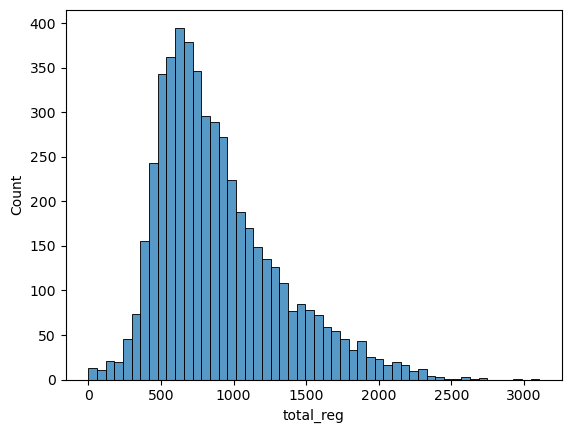

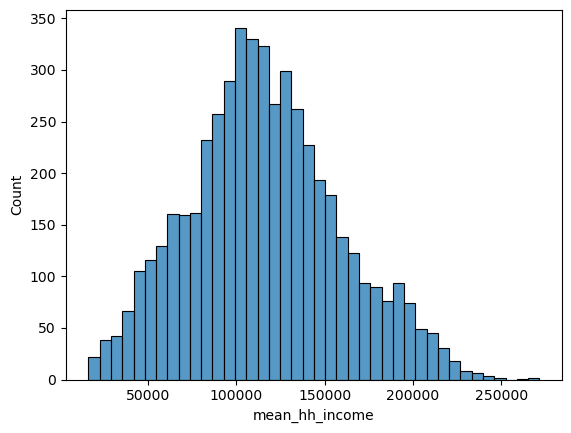

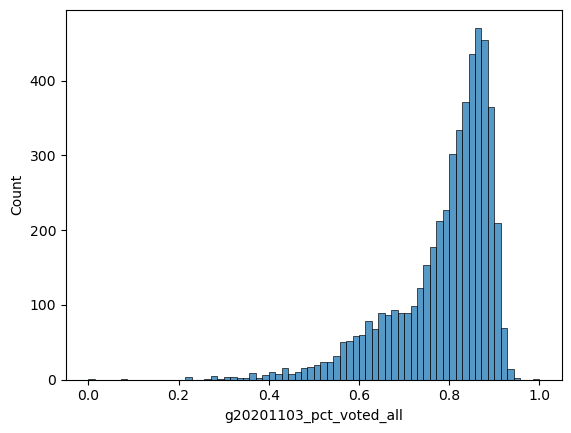

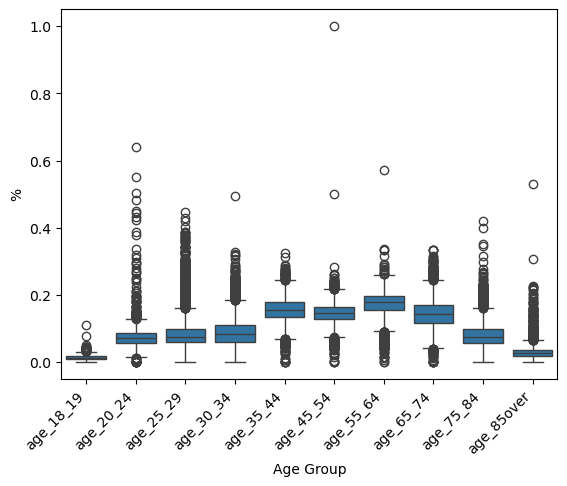

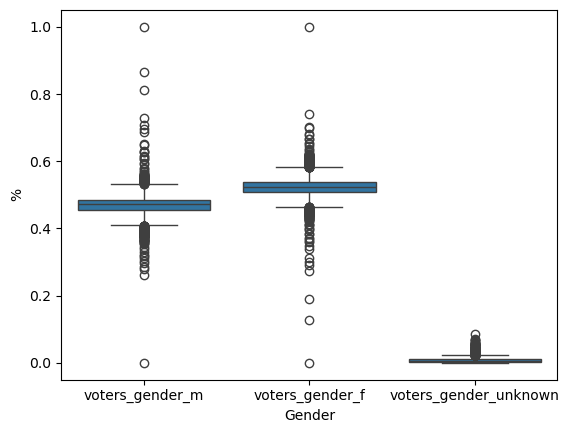

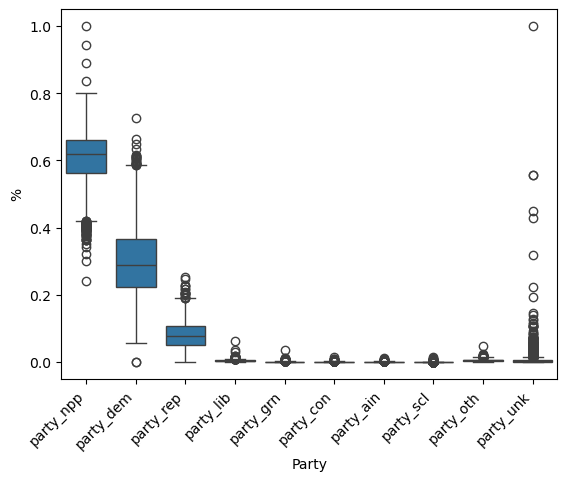

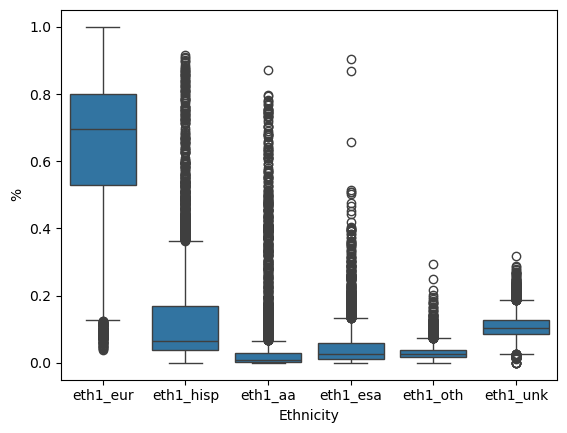

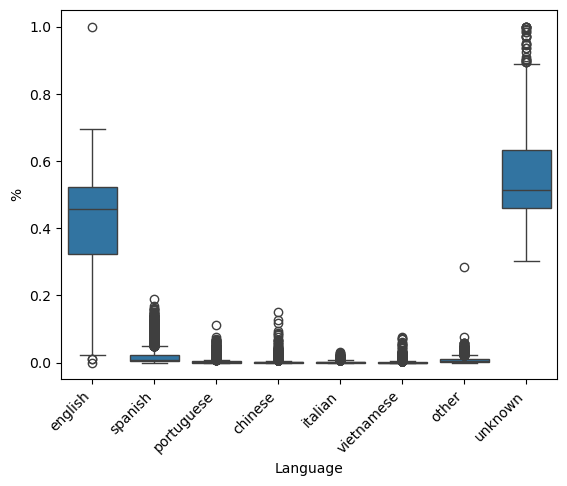

In [13]:
# After transformation

sns.histplot(block_groups, x='total_reg')
# plt.yscale('log')
plt.show()

sns.histplot(block_groups, x='mean_hh_income')
# plt.yscale('log')
plt.show()

sns.histplot(block_groups, x=response)
# plt.yscale('log')
plt.show()

sns.boxplot(block_groups.melt(value_vars=age,var_name='Age Group',value_name='%'),x='Age Group', y='%')
plt.xticks(rotation=45, ha='right')
# plt.yscale('log')
plt.show()

sns.boxplot(block_groups.melt(value_vars=gender,var_name='Gender',value_name='%'), x='Gender', y='%')
# plt.yscale('log')
plt.show()

sns.boxplot(block_groups.melt(value_vars=party,var_name='Party',value_name='%'), x='Party', y='%')
plt.xticks(rotation=45, ha='right')
# plt.yscale('log')
plt.show()

sns.boxplot(block_groups.melt(value_vars=ethnicity1,var_name='Ethnicity',value_name='%'), x='Ethnicity', y='%')
# plt.yscale('log')
plt.show()

sns.boxplot(block_groups.melt(value_vars=languages,var_name='Language',value_name='%'), x='Language', y='%')
plt.xticks(ticks=np.arange(len(languages)),labels=[lang[len('languages_description_'):] for lang in languages], rotation=45, ha='right')
# plt.yscale('log')
plt.show()

## Exploratory Data Analysis

In [14]:
# Use voter_blocks for further analysis, predictors are scaled with RobustScaler
voter_blocks

,total_reg,age_18_19,age_20_24,age_25_29,age_30_34,age_35_44,age_45_54,age_55_64,age_65_74,age_75_84,...,pp20200303_voted_esa,pp20200303_reg_esa,pp20200303_pct_voted_esa,pp20200303_voted_oth,pp20200303_reg_oth,pp20200303_pct_voted_oth,pp20200303_voted_unk,pp20200303_reg_unk,pp20200303_pct_voted_unk,block_group_id
geoid20,,,,,,,,,,,,,,,,,,,,,
250277614022079,0,0,0,0,0,0,0,0,0,0,...,0,0,NaN,0,0,NaN,0,0,NaN,250277614022
250277614022078,0,0,0,0,0,0,0,0,0,0,...,0,0,NaN,0,0,NaN,0,0,NaN,250277614022
250277614022077,0,0,0,0,0,0,0,0,0,0,...,0,0,NaN,0,0,NaN,0,0,NaN,250277614022
250277614022076,0,0,0,0,0,0,0,0,0,0,...,0,0,NaN,0,0,NaN,0,0,NaN,250277614022
250277614022075,0,0,0,0,0,0,0,0,0,0,...,0,0,NaN,0,0,NaN,0,0,NaN,250277614022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250010101001004,0,0,0,0,0,0,0,0,0,0,...,0,0,NaN,0,0,NaN,0,0,NaN,250010101001
250010101001003,0,0,0,0,0,0,0,0,0,0,...,0,0,NaN,0,0,NaN,0,0,NaN,250010101001
250010101001002,0,0,0,0,0,0,0,0,0,0,...,0,0,NaN,0,0,NaN,0,0,NaN,250010101001
